# Fairness policies with continuous-single traces

In this notebook, we compare various heterogeneity-agnostic and heterogeneity-aware LAS, FIFO, and FTF policies, with and without space sharing, on traces with single-GPU jobs only.

## Import statements

In [1]:
from plotting_utils import plot_metric_vs_inverse_lambda, plot_jct_cdf
from utils import get_logfile_paths, average_jct_fn

## Get list of relevant logfiles and define label mapping

In [2]:
logfile_paths = sorted(get_logfile_paths(
    "/future/u/deepakn/gavel/logs/single_gpu_continuous_jobs_final/"))

In [3]:
labels = {"allox": "AlloX",
          "gandiva": "LAS w/ Gandiva SS",
          "fifo": "FIFO",
          "fifo_perf": "Gavel",
          "fifo_packed": "Gavel w/ SS",
          "finish_time_fairness": "FTF",
          "finish_time_fairness_perf": "Gavel",
          "max_min_fairness": "LAS",
          "max_min_fairness_perf": "Gavel",
          "max_min_fairness_packed": "Gavel w/ SS"}

## Plot average JCT vs. input job rate

['fifo', 'fifo_perf', 'fifo_packed']
('FIFO', 0.4)
input_job_rate     0.400000
metric            17.371346
seed               1.000000
dtype: float64
('FIFO', 0.8)
input_job_rate     0.800000
metric            17.437143
seed               1.000000
dtype: float64
('FIFO', 1.2)
input_job_rate     1.200000
metric            17.482193
seed               1.000000
dtype: float64
('FIFO', 1.6)
input_job_rate     1.600000
metric            17.533384
seed               1.000000
dtype: float64
('FIFO', 2.0)
input_job_rate     2.000000
metric            17.985771
seed               1.000000
dtype: float64
('FIFO', 2.4)
input_job_rate     2.400000
metric            18.073415
seed               1.000000
dtype: float64
('FIFO', 2.799999999377778)
input_job_rate     2.800000
metric            18.174134
seed               1.000000
dtype: float64
('FIFO', 3.2)
input_job_rate     3.200000
metric            19.685843
seed               1.000000
dtype: float64
('FIFO', 3.6)
input_job_rate     3.600000
met

/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:81: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


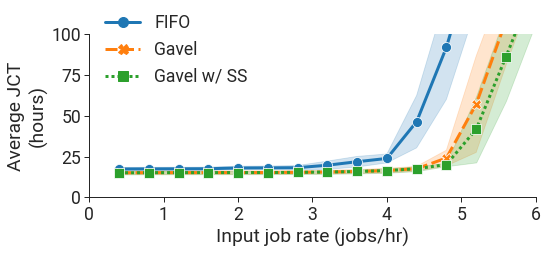

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva', 'allox']
('AlloX', 0.4)
input_job_rate     0.400000
metric            17.371346
seed               1.000000
dtype: float64
('AlloX', 0.8)
input_job_rate     0.800000
metric            17.437143
seed               1.000000
dtype: float64
('AlloX', 1.2)
input_job_rate     1.200000
metric            17.470776
seed               1.000000
dtype: float64
('AlloX', 1.6)
input_job_rate     1.600000
metric            17.370219
seed               1.000000
dtype: float64
('AlloX', 2.0)
input_job_rate     2.000000
metric            16.956415
seed               1.000000
dtype: float64
('AlloX', 2.4)
input_job_rate     2.400000
metric            16.387573
seed               1.000000
dtype: float64
('AlloX', 2.799999999377778)
input_job_rate     2.800000
metric            16.030998
seed               1.000000
dtype: float64
('AlloX', 3.2)
input_job_rate     3.200000
metric            16.028491
seed               1.000

/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:81: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


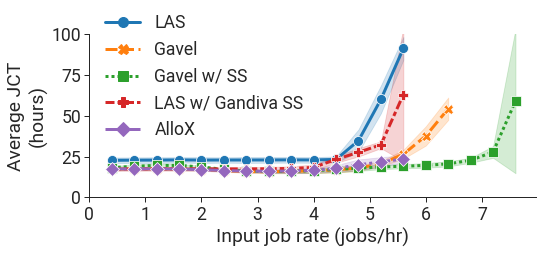

['finish_time_fairness', 'finish_time_fairness_perf', 'allox']
('AlloX', 0.4)
input_job_rate     0.400000
metric            17.371346
seed               1.000000
dtype: float64
('AlloX', 0.8)
input_job_rate     0.800000
metric            17.437143
seed               1.000000
dtype: float64
('AlloX', 1.2)
input_job_rate     1.200000
metric            17.470776
seed               1.000000
dtype: float64
('AlloX', 1.6)
input_job_rate     1.600000
metric            17.370219
seed               1.000000
dtype: float64
('AlloX', 2.0)
input_job_rate     2.000000
metric            16.956415
seed               1.000000
dtype: float64
('AlloX', 2.4)
input_job_rate     2.400000
metric            16.387573
seed               1.000000
dtype: float64
('AlloX', 2.799999999377778)
input_job_rate     2.800000
metric            16.030998
seed               1.000000
dtype: float64
('AlloX', 3.2)
input_job_rate     3.200000
metric            16.028491
seed               1.000000
dtype: float64
('AlloX', 3

/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:81: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


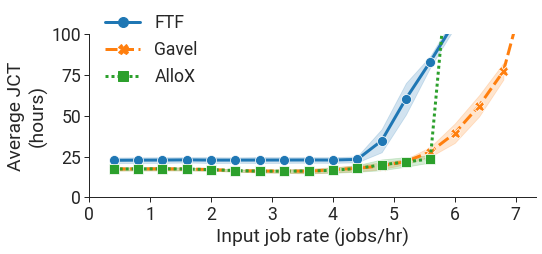

In [4]:
plot_metric_vs_inverse_lambda(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    policies=["fifo",
              "fifo_perf",
              "fifo_packed"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    xmax=6.0,
    ymax=100.0,
    extrapolate=True,
    output_filename="continuous_jobs/single_gpu_fifo_v100=36_p100=36_k80=36.pdf"
)
plot_metric_vs_inverse_lambda(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva",
              "allox"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=100.0,
    extrapolate=False,
    output_filename="continuous_jobs/single_gpu_las_v100=36_p100=36_k80=36.pdf"
)
plot_metric_vs_inverse_lambda(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf",
              "allox"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=100.0,
    extrapolate=True,
    output_filename="continuous_jobs/single_gpu_ftf_v100=36_p100=36_k80=36.pdf"
)

## Plot CDFs of JCT and FTF

['fifo', 'fifo_perf', 'fifo_packed']
Input job rate: 0.40
fifo: 17.58
fifo_perf: 15.31
fifo_packed: 15.31


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


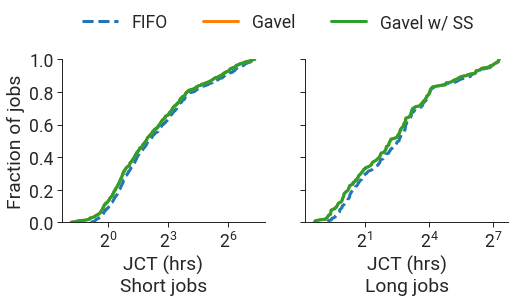

Input job rate: 0.80
fifo: 17.64
fifo_perf: 15.38
fifo_packed: 15.38


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


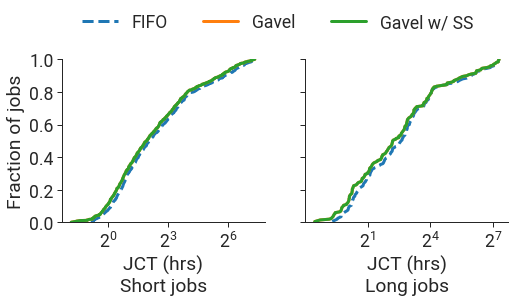

Input job rate: 1.20
fifo: 17.70
fifo_perf: 15.42
fifo_packed: 15.42


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


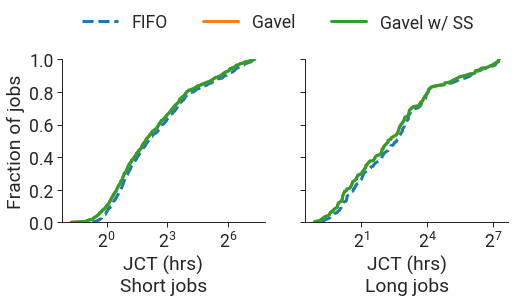

Input job rate: 1.60
fifo: 17.71
fifo_perf: 15.43
fifo_packed: 15.43


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


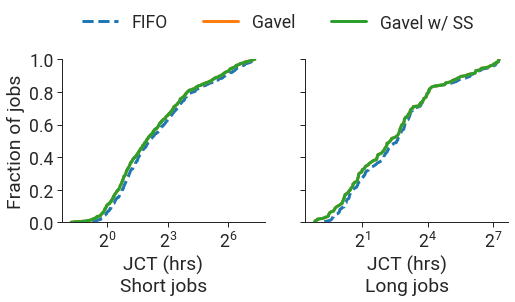

Input job rate: 2.00
fifo: 18.32
fifo_perf: 15.45
fifo_packed: 15.45


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


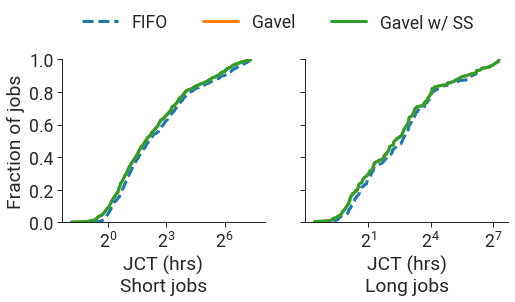

Input job rate: 2.40
fifo: 18.63
fifo_perf: 15.52
fifo_packed: 15.52


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


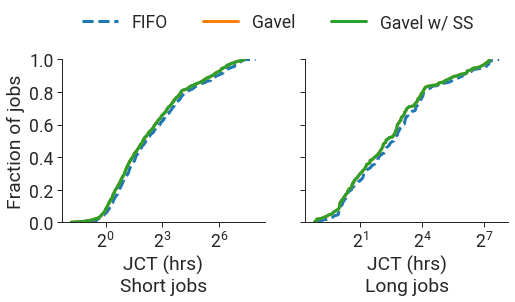

Input job rate: 2.80
fifo: 18.62
fifo_perf: 15.68
fifo_packed: 15.68


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


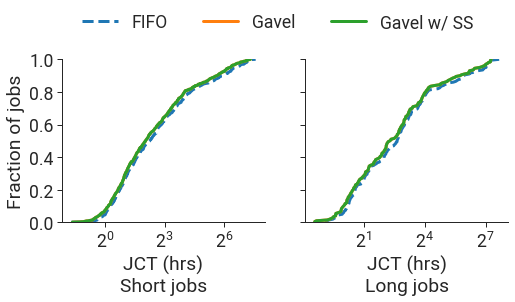

Input job rate: 3.20
fifo: 22.21
fifo_perf: 15.95
fifo_packed: 15.95


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


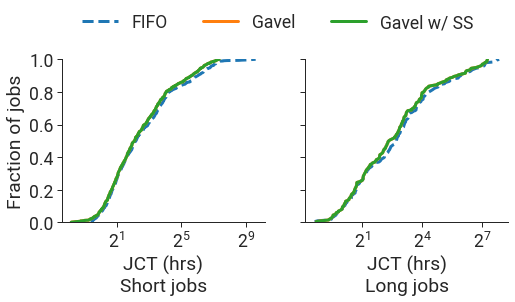

Input job rate: 3.60
fifo: 24.25
fifo_perf: 16.39
fifo_packed: 16.39


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


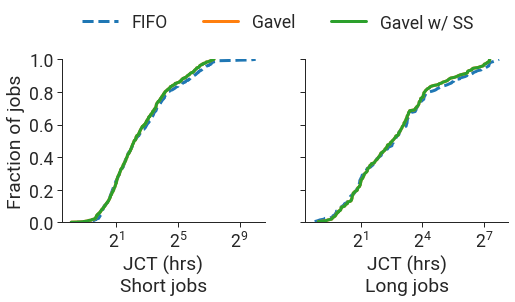

Input job rate: 4.00
fifo: 25.38
fifo_perf: 17.08
fifo_packed: 17.08


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


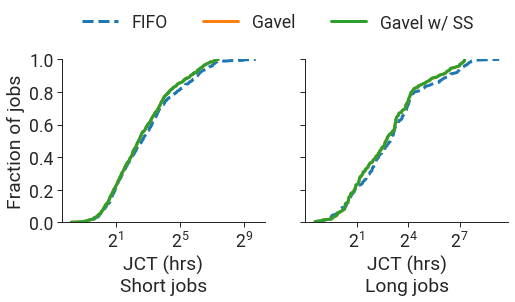

Input job rate: 4.40
fifo: 44.28
fifo_perf: 18.19
fifo_packed: 18.18


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


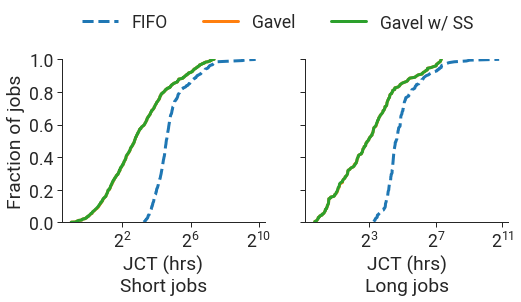

Input job rate: 4.80
fifo: 99.19
fifo_perf: 22.24
fifo_packed: 21.14


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


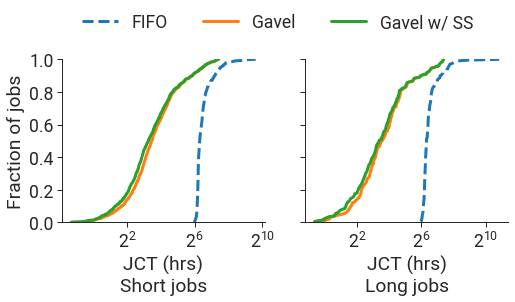

Input job rate: 5.20
fifo: 151.67
fifo_perf: 56.69
fifo_packed: 38.11


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


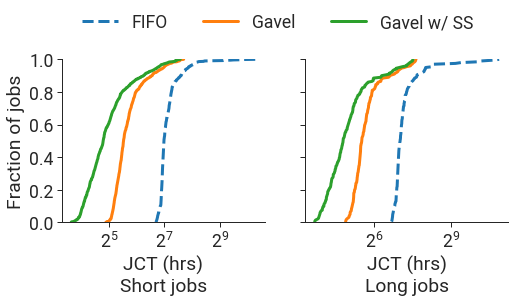

Input job rate: 5.60
fifo_perf: 104.12
fifo_packed: 83.40


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


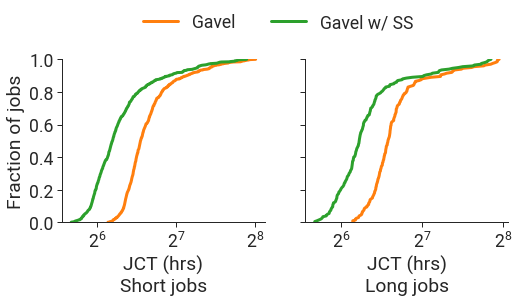

Input job rate: 6.00
fifo_perf: 150.04
fifo_packed: 127.10


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


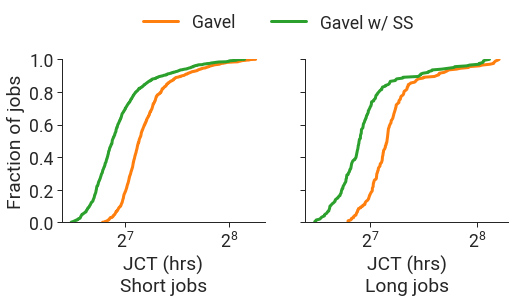

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva']
Input job rate: 0.40
max_min_fairness: 23.26
max_min_fairness_perf: 17.58
max_min_fairness_packed: 18.42
gandiva: 17.58


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


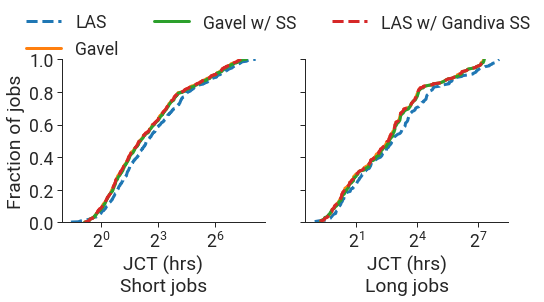

Input job rate: 0.80
max_min_fairness: 23.33
max_min_fairness_perf: 17.64
max_min_fairness_packed: 19.26
gandiva: 17.64


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


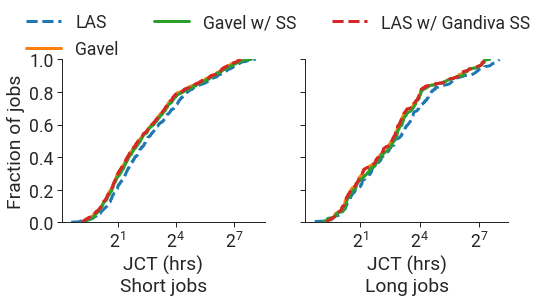

Input job rate: 1.20
max_min_fairness: 23.51
max_min_fairness_perf: 17.67
max_min_fairness_packed: 19.69
gandiva: 17.68


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


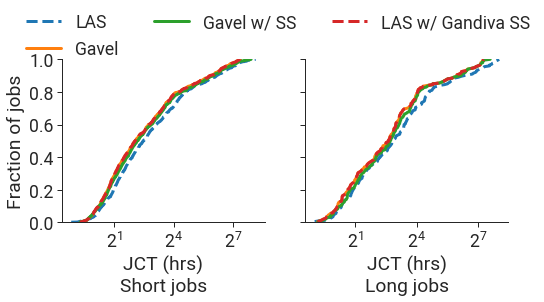

Input job rate: 1.60
max_min_fairness: 23.57
max_min_fairness_perf: 17.48
max_min_fairness_packed: 19.39
gandiva: 17.66


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


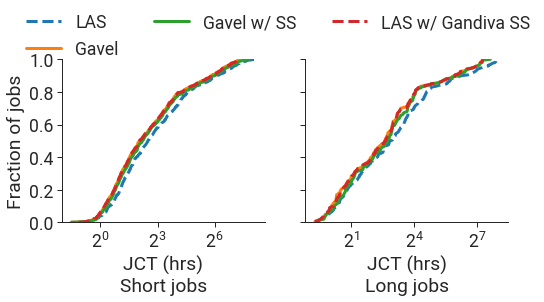

Input job rate: 2.00
max_min_fairness: 23.47
max_min_fairness_perf: 16.95
max_min_fairness_packed: 18.26
gandiva: 17.61


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


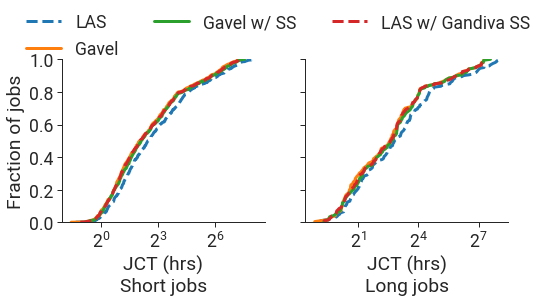

Input job rate: 2.40
max_min_fairness: 23.43
max_min_fairness_perf: 16.39
max_min_fairness_packed: 16.92
gandiva: 17.62


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


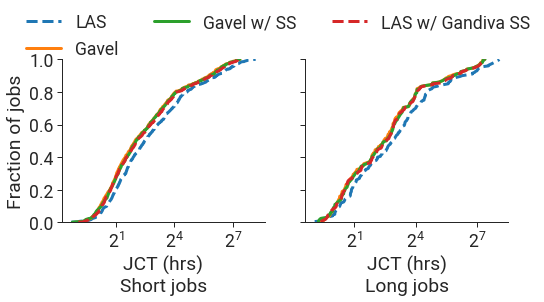

Input job rate: 2.80
max_min_fairness: 23.59
max_min_fairness_perf: 16.04
max_min_fairness_packed: 16.26
gandiva: 17.69


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


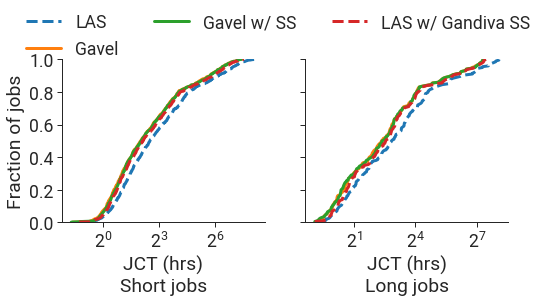

Input job rate: 3.20
max_min_fairness: 23.59
max_min_fairness_perf: 16.08
max_min_fairness_packed: 16.18
gandiva: 17.83


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


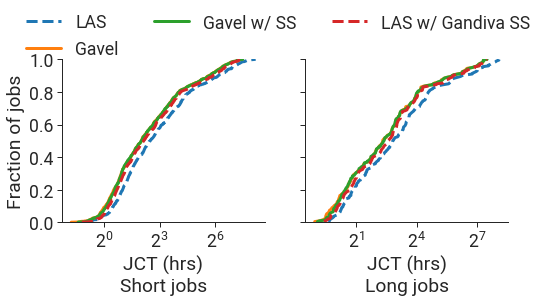

Input job rate: 3.60
max_min_fairness: 23.57
max_min_fairness_perf: 16.38
max_min_fairness_packed: 16.50
gandiva: 18.14


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


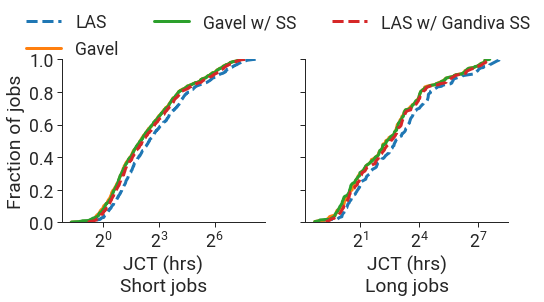

Input job rate: 4.00
max_min_fairness: 23.49
max_min_fairness_perf: 16.82
max_min_fairness_packed: 16.96
gandiva: 18.88


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


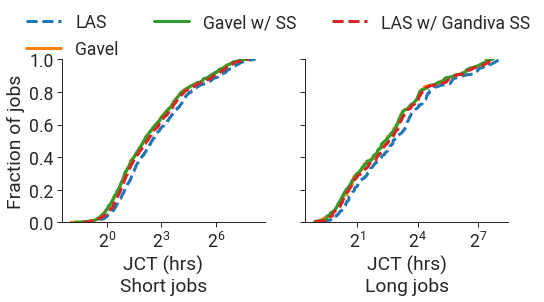

Input job rate: 4.40
max_min_fairness: 23.81
max_min_fairness_perf: 17.48
max_min_fairness_packed: 17.78
gandiva: 25.65


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


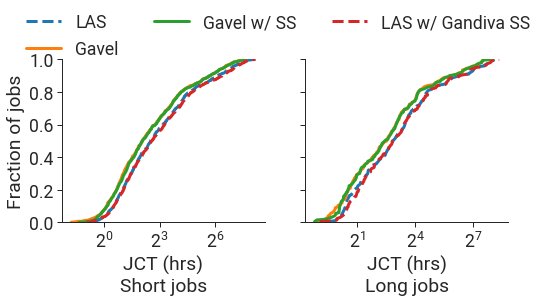

Input job rate: 4.80
max_min_fairness: 35.79
max_min_fairness_perf: 18.97
max_min_fairness_packed: 18.67
gandiva: 30.46


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


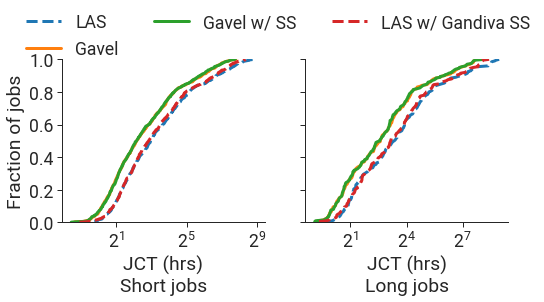

Input job rate: 5.20
max_min_fairness: 63.78
max_min_fairness_perf: 22.02
max_min_fairness_packed: 19.14
gandiva: 34.32


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


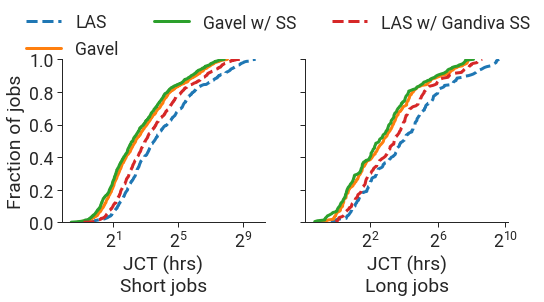

Input job rate: 5.60
max_min_fairness: 95.99
max_min_fairness_perf: 28.96
max_min_fairness_packed: 19.64
gandiva: 42.54


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


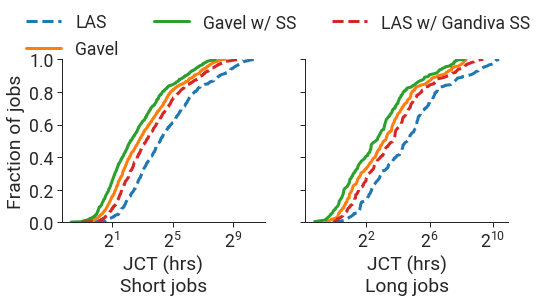

Input job rate: 6.00
max_min_fairness_perf: 41.23
max_min_fairness_packed: 20.42


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


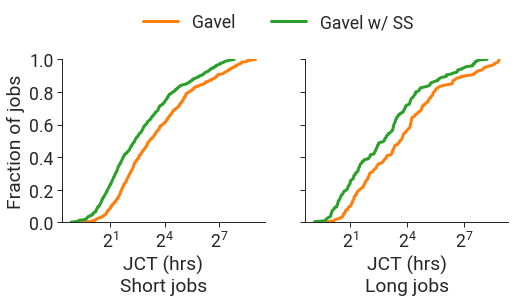

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva', 'allox']
Input job rate: 0.40
max_min_fairness: 23.26
max_min_fairness_perf: 17.58
max_min_fairness_packed: 18.42
gandiva: 17.58
allox: 17.58


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


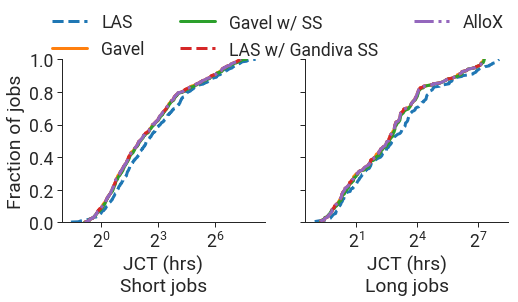

Input job rate: 0.80
max_min_fairness: 23.33
max_min_fairness_perf: 17.64
max_min_fairness_packed: 19.26
gandiva: 17.64
allox: 17.64


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


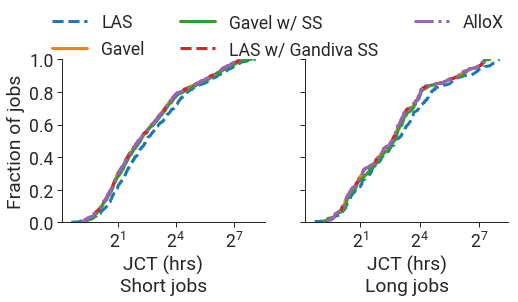

Input job rate: 1.20
max_min_fairness: 23.51
max_min_fairness_perf: 17.67
max_min_fairness_packed: 19.69
gandiva: 17.68
allox: 17.67


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


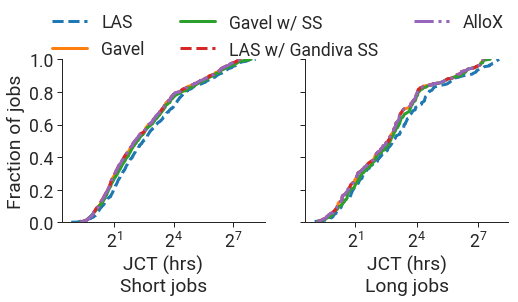

Input job rate: 1.60
max_min_fairness: 23.57
max_min_fairness_perf: 17.48
max_min_fairness_packed: 19.39
gandiva: 17.66
allox: 17.45


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


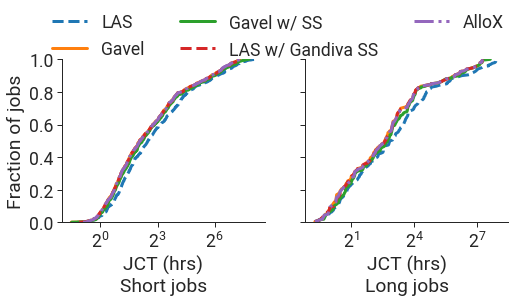

Input job rate: 2.00
max_min_fairness: 23.47
max_min_fairness_perf: 16.95
max_min_fairness_packed: 18.26
gandiva: 17.61
allox: 16.93


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


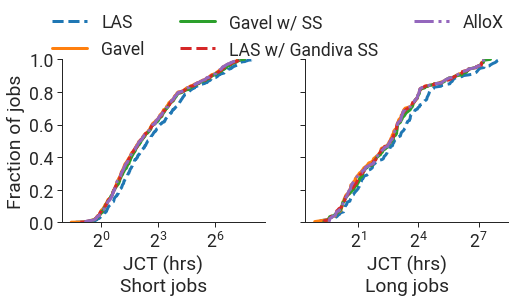

Input job rate: 2.40
max_min_fairness: 23.43
max_min_fairness_perf: 16.39
max_min_fairness_packed: 16.92
gandiva: 17.62
allox: 16.49


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


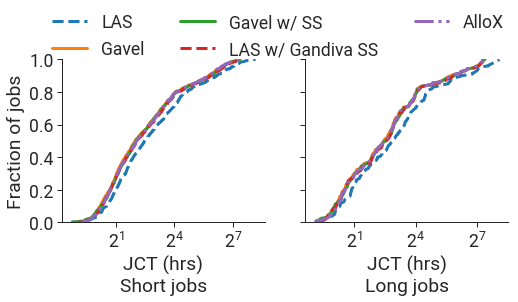

Input job rate: 2.80
max_min_fairness: 23.59
max_min_fairness_perf: 16.04
max_min_fairness_packed: 16.26
gandiva: 17.69
allox: 16.37


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


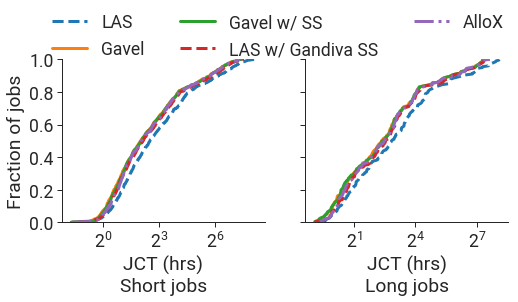

Input job rate: 3.20
max_min_fairness: 23.59
max_min_fairness_perf: 16.08
max_min_fairness_packed: 16.18
gandiva: 17.83
allox: 16.43


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


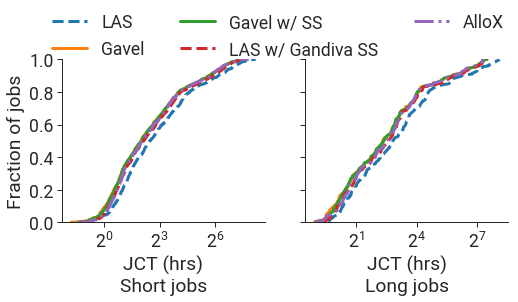

Input job rate: 3.60
max_min_fairness: 23.57
max_min_fairness_perf: 16.38
max_min_fairness_packed: 16.50
gandiva: 18.14
allox: 16.62


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


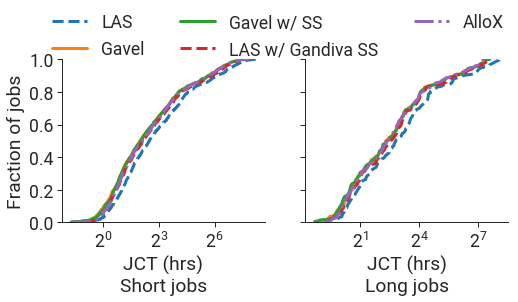

Input job rate: 4.00
max_min_fairness: 23.49
max_min_fairness_perf: 16.82
max_min_fairness_packed: 16.96
gandiva: 18.88
allox: 17.13


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


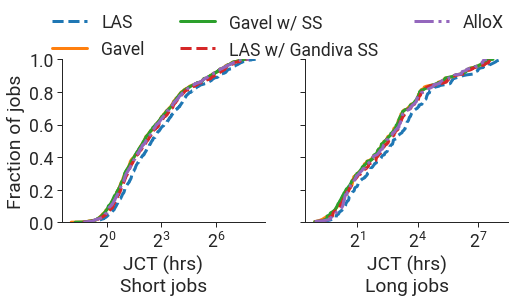

Input job rate: 4.40
max_min_fairness: 23.81
max_min_fairness_perf: 17.48
max_min_fairness_packed: 17.78
gandiva: 25.65
allox: 18.54


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


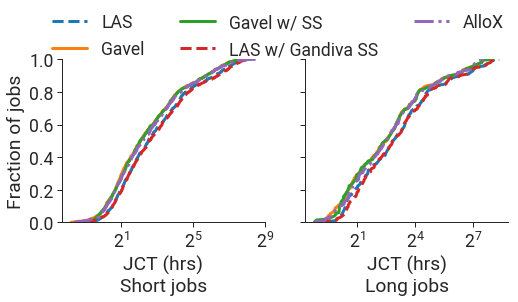

Input job rate: 4.80
max_min_fairness: 35.79
max_min_fairness_perf: 18.97
max_min_fairness_packed: 18.67
gandiva: 30.46
allox: 20.92


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


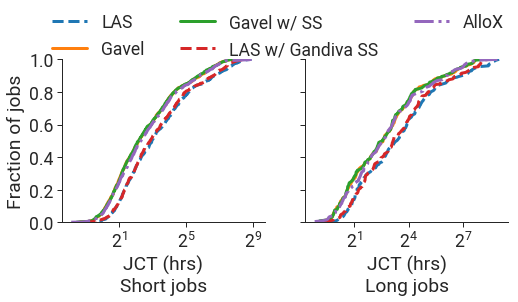

Input job rate: 5.20
max_min_fairness: 63.78
max_min_fairness_perf: 22.02
max_min_fairness_packed: 19.14
gandiva: 34.32
allox: 21.96


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


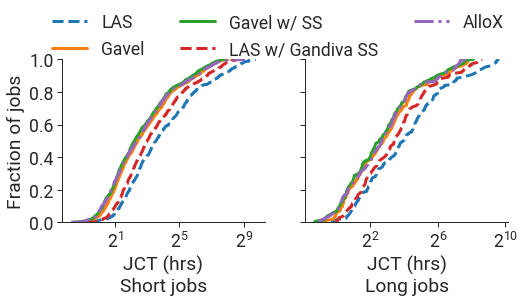

Input job rate: 5.60
max_min_fairness: 95.99
max_min_fairness_perf: 28.96
max_min_fairness_packed: 19.64
gandiva: 42.54
allox: 25.32


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


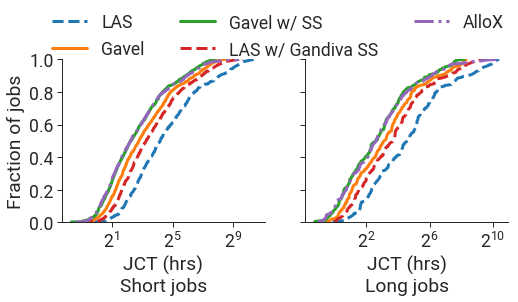

Input job rate: 6.00
max_min_fairness_perf: 41.23
max_min_fairness_packed: 20.42


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


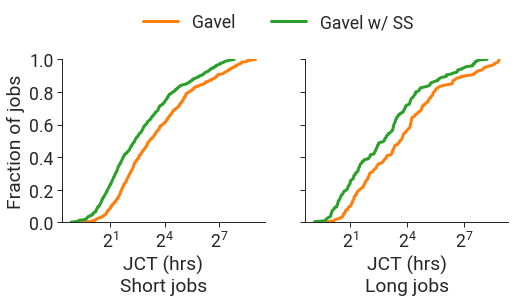

['finish_time_fairness', 'finish_time_fairness_perf', 'allox']
Input job rate: 0.40
finish_time_fairness: 23.26
finish_time_fairness_perf: 17.58
allox: 17.58


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


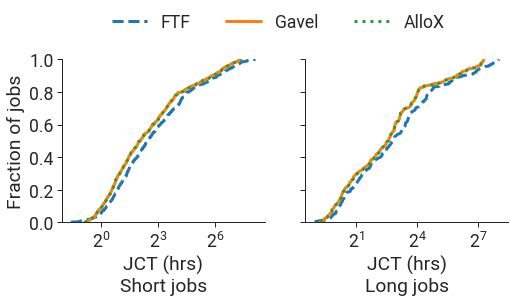

Input job rate: 0.80
finish_time_fairness: 23.33
finish_time_fairness_perf: 17.64
allox: 17.64


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


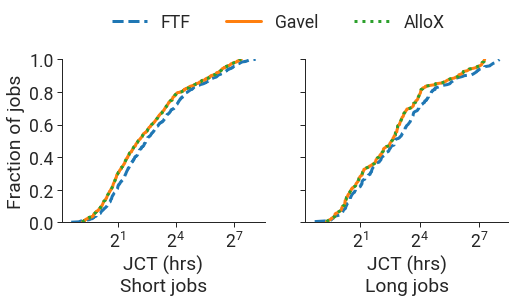

Input job rate: 1.20
finish_time_fairness: 23.51
finish_time_fairness_perf: 17.67
allox: 17.67


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


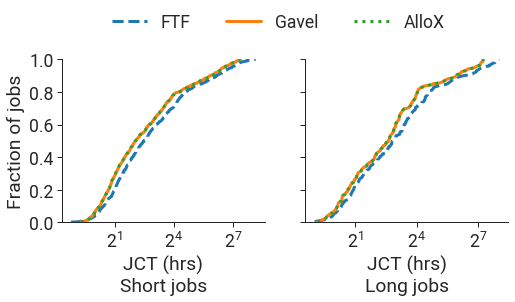

Input job rate: 1.60
finish_time_fairness: 23.58
finish_time_fairness_perf: 17.51
allox: 17.45


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


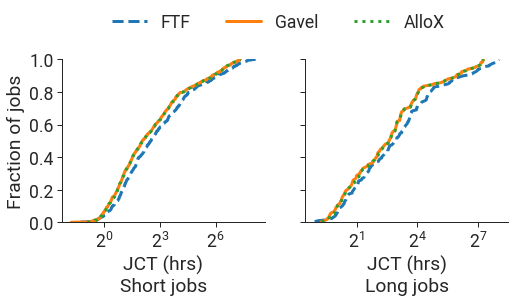

Input job rate: 2.00
finish_time_fairness: 23.47
finish_time_fairness_perf: 17.07
allox: 16.93


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


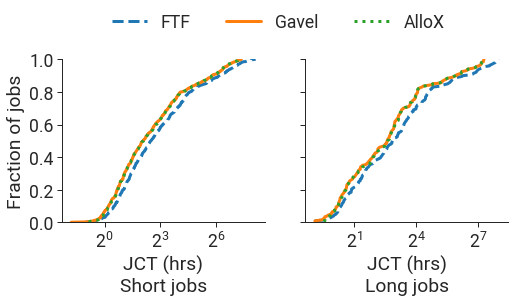

Input job rate: 2.40
finish_time_fairness: 23.38
finish_time_fairness_perf: 16.58
allox: 16.49


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


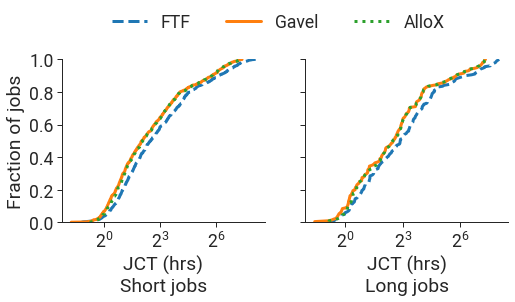

Input job rate: 2.80
finish_time_fairness: 23.51
finish_time_fairness_perf: 16.41
allox: 16.37


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


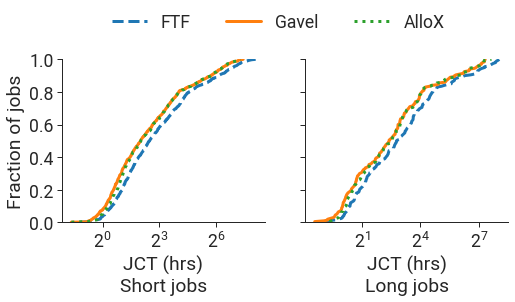

Input job rate: 3.20
finish_time_fairness: 23.58
finish_time_fairness_perf: 16.57
allox: 16.43


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


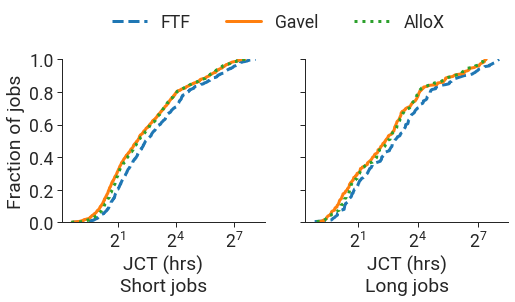

Input job rate: 3.60
finish_time_fairness: 23.50
finish_time_fairness_perf: 16.99
allox: 16.62


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


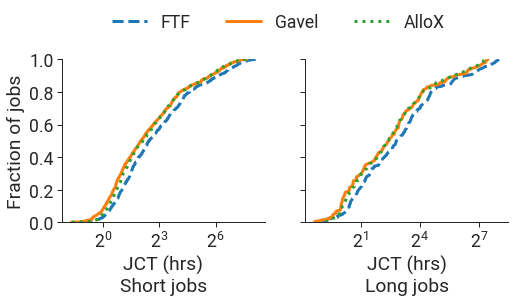

Input job rate: 4.00
finish_time_fairness: 23.43
finish_time_fairness_perf: 17.57
allox: 17.13


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


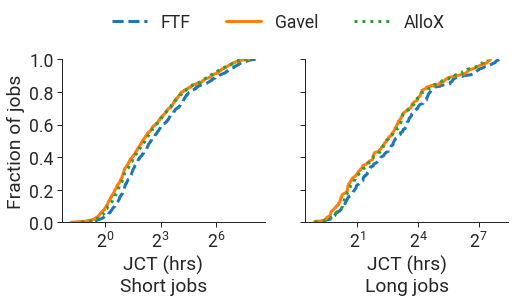

Input job rate: 4.40
finish_time_fairness: 23.75
finish_time_fairness_perf: 18.62
allox: 18.54


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


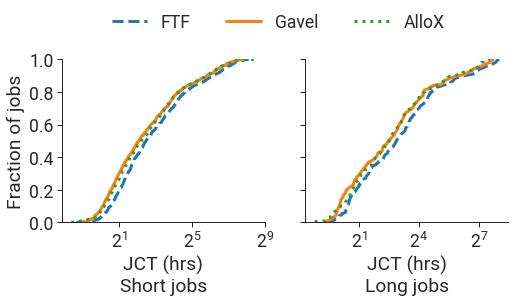

Input job rate: 4.80
finish_time_fairness: 34.93
finish_time_fairness_perf: 20.43
allox: 20.92


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


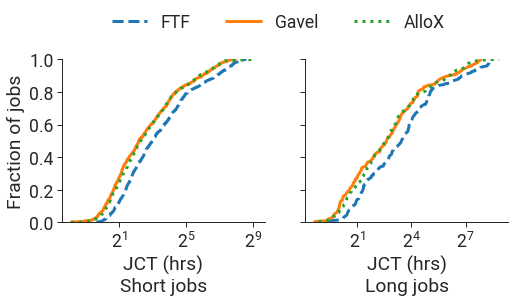

Input job rate: 5.20
finish_time_fairness: 64.46
finish_time_fairness_perf: 23.38
allox: 21.96


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


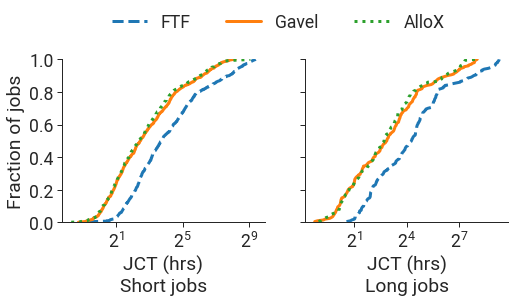

Input job rate: 5.60
finish_time_fairness: 85.54
finish_time_fairness_perf: 30.47
allox: 25.32


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


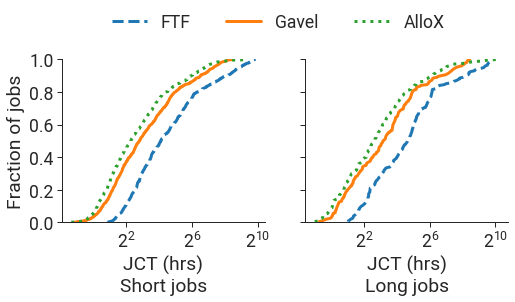

Input job rate: 6.00
finish_time_fairness: 109.14
finish_time_fairness_perf: 43.05


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


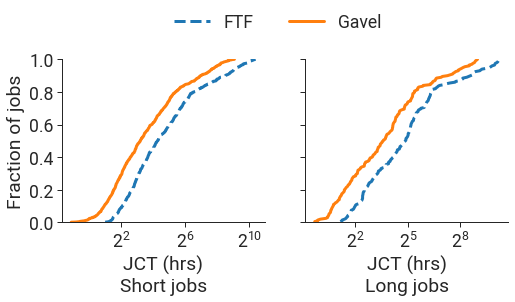

In [5]:
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["fifo",
              "fifo_perf",
              "fifo_packed"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_fifo_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_las_without_allox_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva",
              "allox"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_las_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf",
              "allox"],
    min_job_id=4000, max_job_id=5000,
    output_directory="continuous_jobs/jct_cdf/single_gpu_ftf_v100=36_p100=36_k80=36/"
)

['max_min_fairness', 'max_min_fairness_perf', 'max_min_fairness_packed', 'gandiva', 'allox']
Input job rate: 0.40
max_min_fairness: 1.00
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.89
gandiva: 0.84
allox: 0.84


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


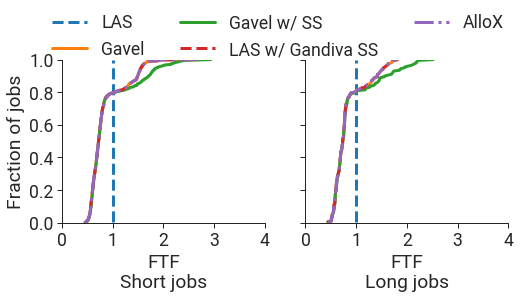

Input job rate: 0.80
max_min_fairness: 1.00
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.95
gandiva: 0.84
allox: 0.84


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


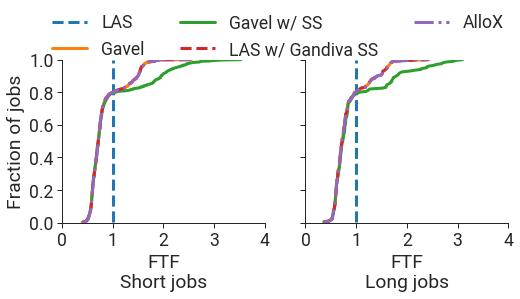

Input job rate: 1.20
max_min_fairness: 1.00
max_min_fairness_perf: 0.84
max_min_fairness_packed: 0.98
gandiva: 0.84
allox: 0.84


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


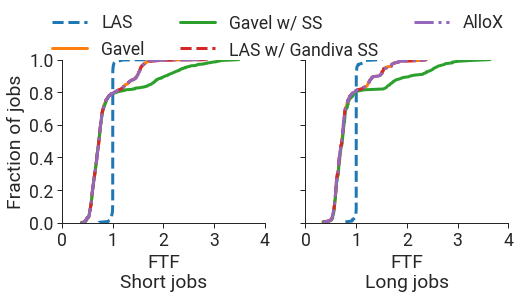

Input job rate: 1.60
max_min_fairness: 1.00
max_min_fairness_perf: 0.83
max_min_fairness_packed: 0.96
gandiva: 0.83
allox: 0.83


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


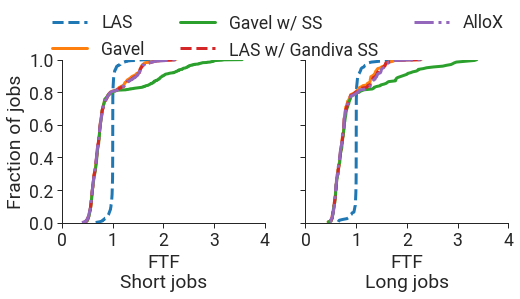

Input job rate: 2.00
max_min_fairness: 1.01
max_min_fairness_perf: 0.80
max_min_fairness_packed: 0.90
gandiva: 0.83
allox: 0.82


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


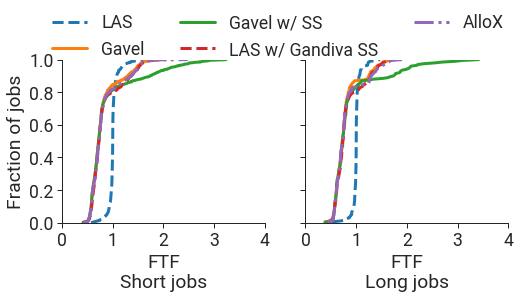

Input job rate: 2.40
max_min_fairness: 1.01
max_min_fairness_perf: 0.78
max_min_fairness_packed: 0.83
gandiva: 0.83
allox: 0.81


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


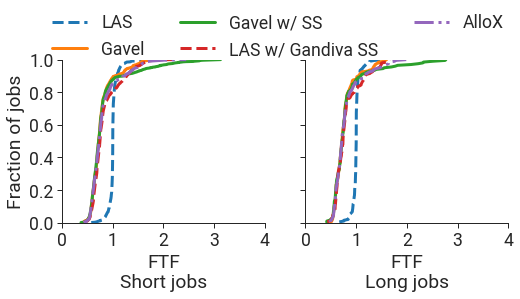

Input job rate: 2.80
max_min_fairness: 1.00
max_min_fairness_perf: 0.73
max_min_fairness_packed: 0.75
gandiva: 0.81
allox: 0.78


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


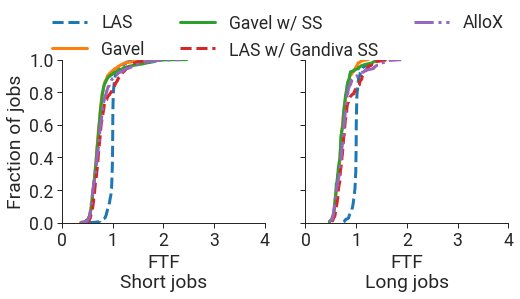

Input job rate: 3.20
max_min_fairness: 1.00
max_min_fairness_perf: 0.72
max_min_fairness_packed: 0.73
gandiva: 0.81
allox: 0.78


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


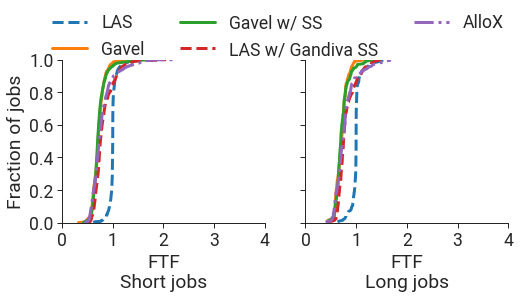

Input job rate: 3.60
max_min_fairness: 1.01
max_min_fairness_perf: 0.73
max_min_fairness_packed: 0.73
gandiva: 0.82
allox: 0.79


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


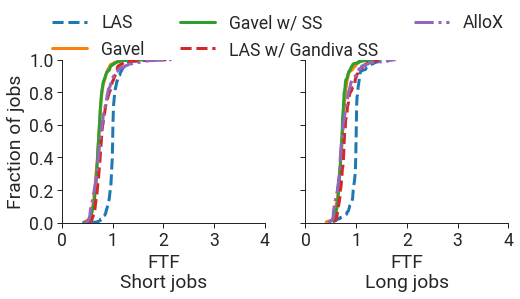

Input job rate: 4.00
max_min_fairness: 1.00
max_min_fairness_perf: 0.75
max_min_fairness_packed: 0.75
gandiva: 0.83
allox: 0.81


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


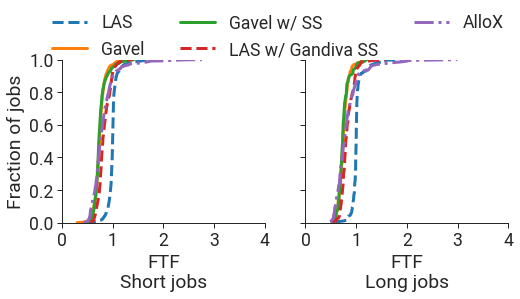

Input job rate: 4.40
max_min_fairness: 1.00
max_min_fairness_perf: 0.75
max_min_fairness_packed: 0.77
gandiva: 1.08
allox: 0.83


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


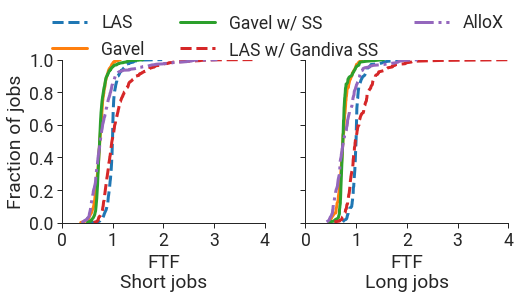

Input job rate: 4.80
max_min_fairness: 1.05
max_min_fairness_perf: 0.64
max_min_fairness_packed: 0.63
gandiva: 1.03
allox: 0.73


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


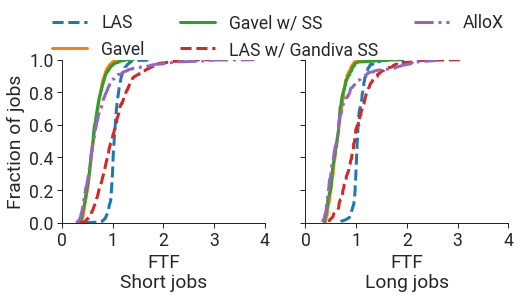

Input job rate: 5.20
max_min_fairness: 0.92
max_min_fairness_perf: 0.41
max_min_fairness_packed: 0.36
gandiva: 0.65
allox: 0.40


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


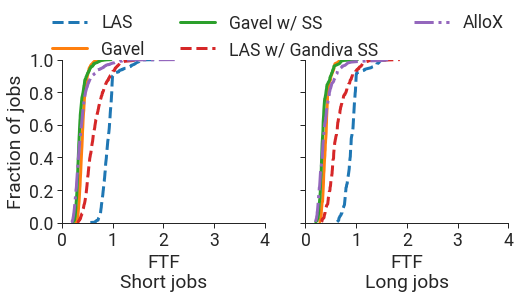

Input job rate: 5.60
max_min_fairness: 0.96
max_min_fairness_perf: 0.37
max_min_fairness_packed: 0.26
gandiva: 0.54
allox: 0.28


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


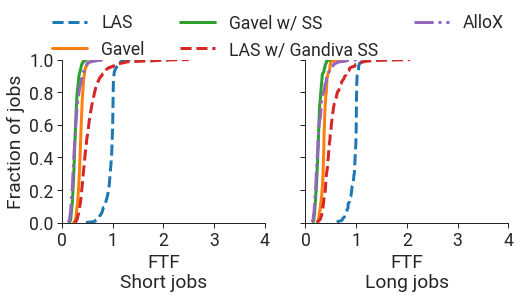

Input job rate: 6.00
['finish_time_fairness', 'finish_time_fairness_perf', 'allox']
Input job rate: 0.40
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.84
allox: 0.84


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


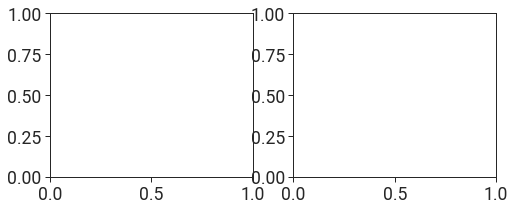

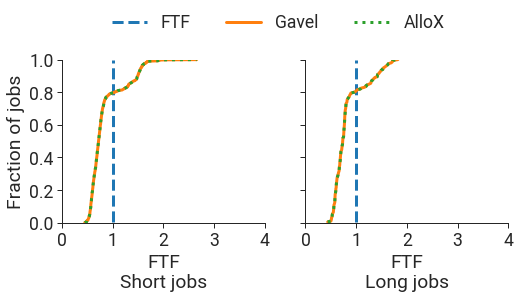

Input job rate: 0.80
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.84
allox: 0.84


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


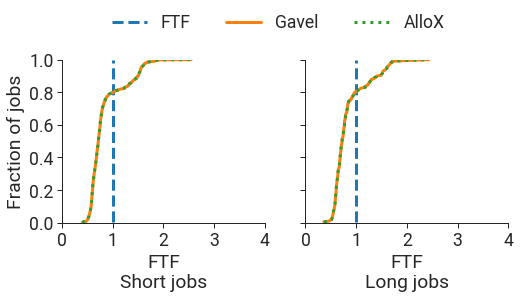

Input job rate: 1.20
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.84
allox: 0.84


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


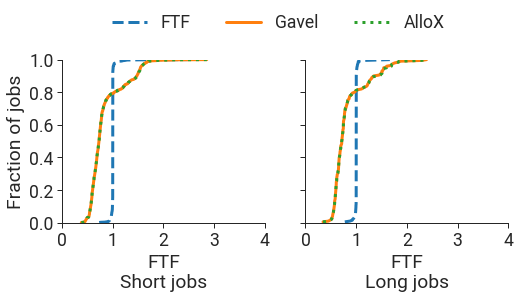

Input job rate: 1.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.82
allox: 0.83


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


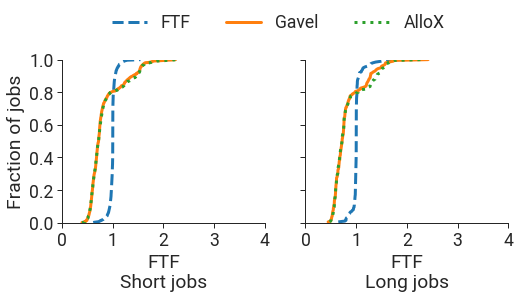

Input job rate: 2.00
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.80
allox: 0.82


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


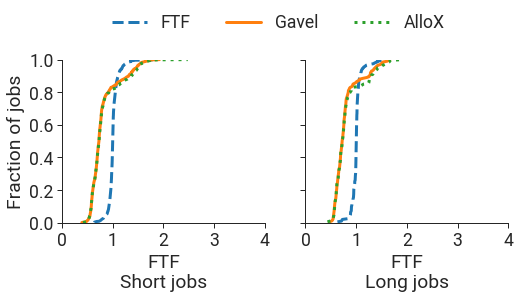

Input job rate: 2.40
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.77
allox: 0.81


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


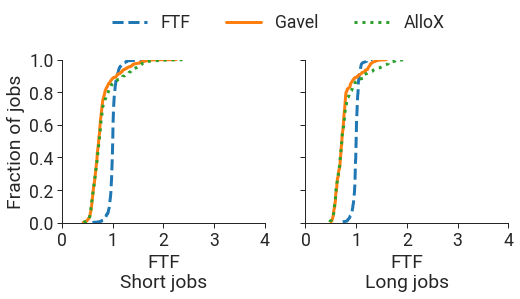

Input job rate: 2.80
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.73
allox: 0.78


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


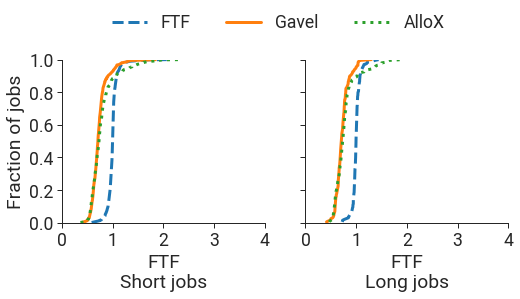

Input job rate: 3.20
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.73
allox: 0.78


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


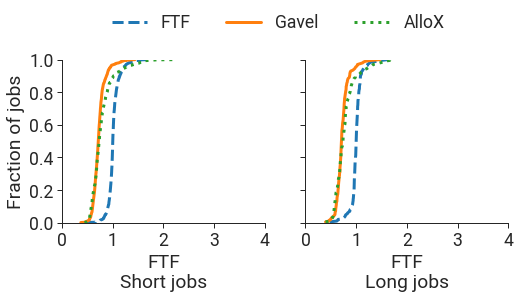

Input job rate: 3.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.73
allox: 0.79


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


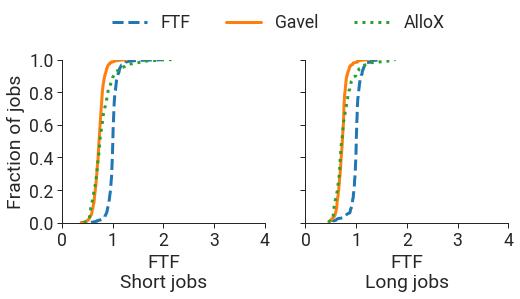

Input job rate: 4.00
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.75
allox: 0.81


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


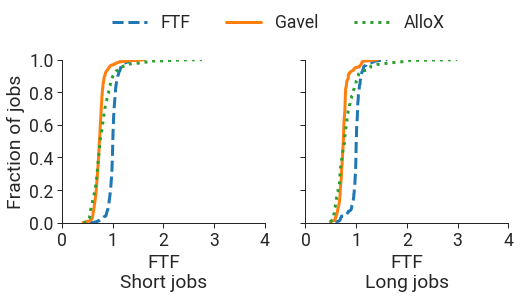

Input job rate: 4.40
finish_time_fairness: 1.01
finish_time_fairness_perf: 0.77
allox: 0.83


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


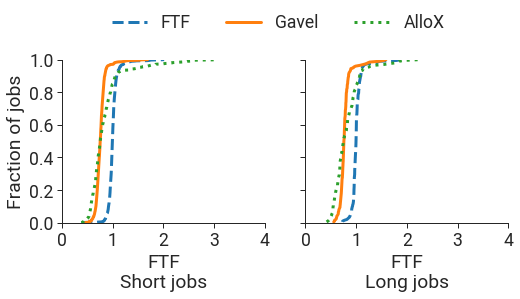

Input job rate: 4.80
finish_time_fairness: 1.09
finish_time_fairness_perf: 0.64
allox: 0.73


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


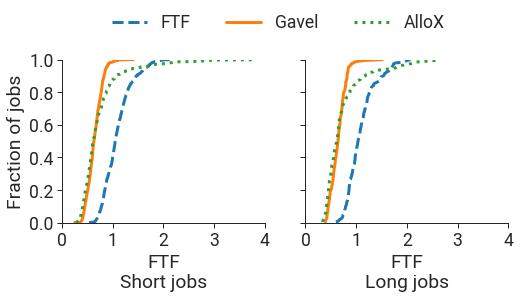

Input job rate: 5.20
finish_time_fairness: 1.07
finish_time_fairness_perf: 0.40
allox: 0.40


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


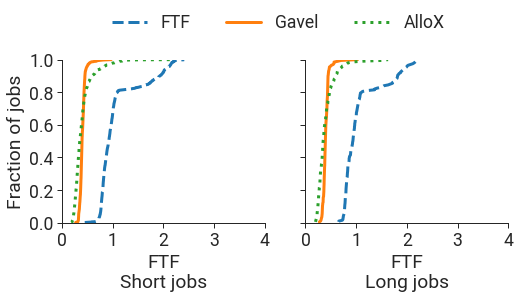

Input job rate: 5.60
finish_time_fairness: 1.00
finish_time_fairness_perf: 0.36
allox: 0.28


/lfs/1/deepak/gpusched/scheduler/notebooks/figures/evaluation/plotting_utils.py:261: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  axes[1].transAxes)


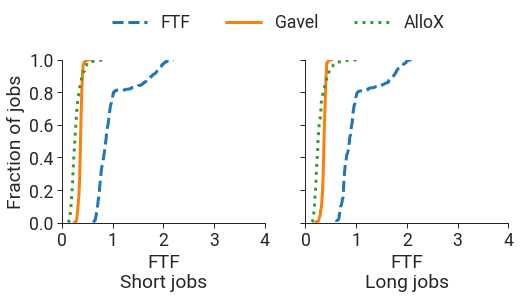

Input job rate: 6.00


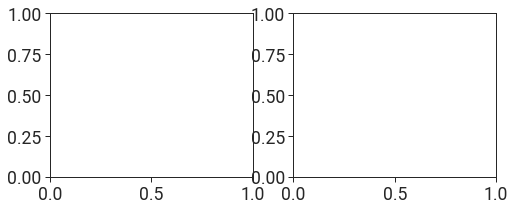

In [6]:
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["max_min_fairness",
              "max_min_fairness_perf",
              "max_min_fairness_packed",
              "gandiva",
              "allox"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/single_gpu_las_v100=36_p100=36_k80=36/"
)
plot_jct_cdf(
    logfile_paths,
    labels,
    v100s=36, p100s=36, k80s=36,
    max_input_job_rate=6.0,
    policies=["finish_time_fairness",
              "finish_time_fairness_perf",
              "allox"],
    min_job_id=4000, max_job_id=5000,
    finish_time_fairness=True,
    output_directory="continuous_jobs/ftf_cdf/single_gpu_ftf_v100=36_p100=36_k80=36/"
)